In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## What is Funnel Analysis?
Funnel analysis is used to track how users progress through key steps on a website or app. In e-commerce, it helps answer:

- How many users viewed products?

- How many added to cart?

- How many completed purchases?


This helps identify drop-offs and optimize for better conversions.

## Goal of this Notebook
We’ll analyze the user journey through 3 funnel stages:
- Product Detail View (action_type = 2)
- Add to Cart (action_type = 3)
- Transaction/Purchase (action_type = 6)

## Dataset Used
### Source: bigquery-public-data.google_analytics_sample.ga_sessions_20170801

- Structure: Each row is a session; hits (nested field) captures user interactions

- Period: August 1st, 2017

- Data Size: ~900,000 sessions, ~50,000+ hits with eCommerce activity

In [3]:
#Importing bigquery
from google.cloud import bigquery

#Creating a client object.
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


# 1. Extract Action-Type Data from UNNEST(hits)
Google Analytics stores interaction data in a nested hits array. To analyze actions (like product views, cart adds, and purchases), we need to flatten the hits.

In [4]:
query = f"""
WITH unnested_hits AS (
  SELECT
    fullVisitorId,
    visitId,
    date,
    hits.type AS hit_type,
    CAST(hits.eCommerceAction.action_type AS INT) AS action_type
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', date)) = 2017  -- Parsing the date properly
)
SELECT
  CASE
      WHEN action_type = 2 THEN 'Product Detail'
      WHEN action_type = 3 THEN 'Add to Cart'
      ELSE 'Purchases'
  END AS action_type,
  COUNT(DISTINCT CONCAT(fullVisitorId, "-", visitId)) AS sessions
FROM
  unnested_hits
WHERE
  action_type IN (2, 3, 6) -- 2: detail view, 3: add to cart, 6: purchase
GROUP BY action_type
ORDER BY action_type;

"""
query = client.query(query)

df_unnested_hits = query.to_dataframe()
df_unnested_hits.to_csv('/kaggle/working/unnested_hits.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [5]:
df_unnested_hits


,action_type,sessions
0,Add to Cart,27711
1,Product Detail,65464
2,Purchases,6351


## Interpreting Funnel Analysis Results
1. **Product Detail** Views (action_type = 2)
   This is the number of sessions where users viewed a product detail page.
   65,464 sessions indicate strong browsing behavior or catalog interest.
   
3. **Add to Cart** (action_type = 3)
   Sessions where users added at least one item to their cart.
   Dropped to 27,711 sessions, showing only ~42% of browsers added items.

   
5. **Purchases** (action_type = 6)
   Final purchase action taken in a session.
   Further down to 6,351 sessions, a ~23% cart-to-purchase rate.


A large number of users view products, but fewer add to cart, and even fewer complete purchases.

This reflects typical user behavior and highlights potential areas to improve conversion—like optimizing product pages, simplifying cart experience, or offering incentives.

A large number of users view products, but fewer add to cart, and even fewer complete purchases.

This reflects typical user behavior and highlights potential areas to improve conversion—like optimizing product pages, simplifying cart experience, or offering incentives.

# 2. Step by step conversion

In [6]:
query = f"""
 WITH unnested_hits AS (
  SELECT
    fullVisitorId,
    visitId,
    CONCAT(fullVisitorId, '-', visitId) AS session_id,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action_type
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', date)) = 2017

),
session_actions AS (
  SELECT
    session_id,
    ARRAY_AGG(DISTINCT action_type) AS actions
  FROM
    unnested_hits
  WHERE action_type IN (2, 3, 6)
  GROUP BY session_id
),
step_flags AS (
  SELECT
    session_id,
    -- Boolean flags for each action type using `IN` to check if the actions array contains a type
    IF(2 IN UNNEST(actions), 1, 0) AS viewed,
    IF(3 IN UNNEST(actions), 1, 0) AS added_to_cart,
    IF(6 IN UNNEST(actions), 1, 0) AS purchased
  FROM session_actions
)
SELECT
  COUNTIF(viewed = 1) AS product_view_sessions,
  COUNTIF(viewed = 1 AND added_to_cart = 1) AS view_to_cart_sessions,
  COUNTIF(added_to_cart = 1 AND purchased = 1) AS cart_to_purchase_sessions,
  COUNTIF(viewed = 1 AND purchased = 1) AS view_to_purchase_sessions
FROM step_flags;
"""
query = client.query(query)
df_step_by_step_conv_rates = query.to_dataframe()
df_step_by_step_conv_rates.to_csv('/kaggle/working/step_by_step_conv_rates.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [7]:
df_step_by_step_conv_rates

,product_view_sessions,view_to_cart_sessions,cart_to_purchase_sessions,view_to_purchase_sessions
0,65464,23352,5468,4862


**We can make a funnel chart for this.**

**Funnel Analysis Insights (2017)**

- In 2017, there were around 65,464 sessions where users viewed a product. Out of these, 35.67% progressed to adding the product to their cart (≈23,352 sessions). From those who added to the cart, only 23.42% went on to complete a purchase (≈5,468 sessions). When looking at the full journey from viewing a product to making a purchase, only 7.43% of sessions converted (≈4,862 sessions).

- These numbers indicate notable drop-offs at each stage—especially from cart to purchase—highlighting potential friction in the checkout process or lack of purchasing intent.



# 3. Drop-off Points — Identifying Funnel Abandonment

In [8]:
  query = f"""
  WITH unnested_hits AS (
  SELECT
    fullVisitorId,
    visitId,
    CONCAT(fullVisitorId, '-', visitId) AS session_id,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action_type
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', date)) = 2017
),
session_actions AS (
  SELECT
    session_id,
    ARRAY_AGG(DISTINCT action_type) AS actions
  FROM
    unnested_hits
  WHERE action_type IN (2, 3, 6)
  GROUP BY session_id
),
step_flags AS (
  SELECT
    session_id,
    IF(2 IN UNNEST(actions), 1, 0) AS viewed,
    IF(3 IN UNNEST(actions), 1, 0) AS added_to_cart,
    IF(6 IN UNNEST(actions), 1, 0) AS purchased
  FROM session_actions
)
SELECT
  COUNTIF(viewed = 1) AS product_view_sessions,
  COUNTIF(viewed = 1 AND added_to_cart = 0) AS viewed_but_not_cart,
  COUNTIF(added_to_cart = 1 AND purchased = 0) AS cart_abandonments,
  COUNTIF(added_to_cart = 1 AND purchased = 1) AS cart_to_purchase_sessions,
  COUNTIF(viewed = 1 AND added_to_cart = 1 AND purchased = 1) AS view_to_purchase_sessions,
  
  -- Calculate the drop-off percentages at each stage
  SAFE_DIVIDE(COUNTIF(viewed = 1 AND added_to_cart = 0), COUNTIF(viewed = 1)) * 100 AS viewed_but_not_cart_percentage,
  SAFE_DIVIDE(COUNTIF(added_to_cart = 1 AND purchased = 0), COUNTIF(added_to_cart = 1)) * 100 AS cart_abandonment_percentage,
  SAFE_DIVIDE(COUNTIF(added_to_cart = 1 AND purchased = 1), COUNTIF(added_to_cart = 1)) * 100 AS cart_to_purchase_percentage,
  SAFE_DIVIDE(COUNTIF(viewed = 1 AND added_to_cart = 1 AND purchased = 1), COUNTIF(viewed = 1)) * 100 AS view_to_purchase_percentage
FROM step_flags;

"""

query = client.query(query)
df_drop_offs = query.to_dataframe()
df_drop_offs.to_csv('/kaggle/working/drop_offs.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [9]:
df_drop_offs

,product_view_sessions,viewed_but_not_cart,cart_abandonments,cart_to_purchase_sessions,view_to_purchase_sessions,viewed_but_not_cart_percentage,cart_abandonment_percentage,cart_to_purchase_percentage,view_to_purchase_percentage
0,65464,42112,22243,5468,4731,64.328486,80.267764,19.732236,7.226873


**DROP OFF Analysis** 
Choke Points:

- 64.33% drop-off between product view and add to cart suggests users are not convinced to add items.

- 80.27% cart abandonment shows many users fail to complete their purchase after adding items.

Conversion:

- 7.23% conversion from view to purchase, and 19.73% conversion from cart to purchase indicate the major issues are in the earlier stages (view to cart).

Focus:

- Improve product engagement to boost view to cart conversion.

- Optimize the checkout flow to reduce cart abandonment.

# 4. Time Between Steps
To analyze time between steps in the funnel, we want to measure the average time it takes for users to move from one step to another. Specifically, we are interested in the following transitions:

- Product View → Add to Cart: Time it takes for a user to view a product and then add it to the cart.

- Add to Cart → Purchase: Time it takes from adding an item to the cart to completing the purchase.

In [10]:
query = f"""
WITH unnested_hits AS (
  SELECT
    fullVisitorId,
    visitId,
    CONCAT(fullVisitorId, '-', visitId) AS session_id,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action_type,
    TIMESTAMP_MILLIS(1000 * visitStartTime + hits.time) AS hit_timestamp
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', date)) = 2017
    AND CAST(hits.eCommerceAction.action_type AS INT64) IN (2, 3, 6) -- View, Add to Cart, Purchase
),
session_steps AS (
  SELECT
    session_id,
    MIN(IF(action_type = 2, hit_timestamp, NULL)) AS view_time,
    MIN(IF(action_type = 3, hit_timestamp, NULL)) AS cart_time,
    MIN(IF(action_type = 6, hit_timestamp, NULL)) AS purchase_time
  FROM unnested_hits
  GROUP BY session_id
),
time_differences AS (
  SELECT
    session_id,
    TIMESTAMP_DIFF(cart_time, view_time, SECOND) AS view_to_cart_seconds,
    TIMESTAMP_DIFF(purchase_time, cart_time, SECOND) AS cart_to_purchase_seconds
  FROM session_steps
  WHERE view_time IS NOT NULL AND cart_time IS NOT NULL AND purchase_time IS NOT NULL
)
SELECT
  COUNT(*) AS complete_funnel_sessions,
  ROUND(AVG(view_to_cart_seconds), 2) AS avg_view_to_cart_sec,
  ROUND(AVG(cart_to_purchase_seconds), 2) AS avg_cart_to_purchase_sec
FROM time_differences;
"""
query = client.query(query)
df_time_btw_steps = query.to_dataframe()
df_time_btw_steps.to_csv('/kaggle/working/time_btw_steps.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [11]:
df_time_btw_steps

,complete_funnel_sessions,avg_view_to_cart_sec,avg_cart_to_purchase_sec
0,4731,55.36,766.36


# 5. Session Path Analysis
**Objective**: Analyze the sequence of actions within user sessions to understand the flow of interactions.

**Purpose**: This helps uncover how users are moving between stages in the funnel. For example, are they viewing multiple products, adding items to cart, removing items, and then exiting the session? This step dives into the order of actions that users take.

In [12]:
query = f"""
WITH unnested_hits AS (
  SELECT
    fullVisitorId,
    visitId,
    CONCAT(fullVisitorId, '-', visitId) AS session_id,
    TIMESTAMP_MILLIS(1000 * visitStartTime + hits.time) AS hit_timestamp,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action_type
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', date)) = 2017
    AND hits.eCommerceAction.action_type IN ('2', '3', '6')  -- still okay here as strings
),
session_paths AS (
  SELECT
    session_id,
    ARRAY_AGG(
      CASE action_type
        WHEN 2 THEN 'Product View'
        WHEN 3 THEN 'Add to Cart'
        WHEN 6 THEN 'Purchase'
        ELSE 'Other'
      END
      ORDER BY hit_timestamp
    ) AS ordered_actions
  FROM unnested_hits
  GROUP BY session_id
)

SELECT
  ordered_actions,
  COUNT(*) AS session_count
FROM
  session_paths
GROUP BY
  ordered_actions
ORDER BY
  session_count DESC
LIMIT 10;
"""
query = client.query(query)
df_session_path_analysis = query.to_dataframe()
df_session_path_analysis.to_csv('/kaggle/working/session_path_analysis.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [13]:
df_session_path_analysis

,ordered_actions,session_count
0,[Product View],22464
1,"[Product View, Product View]",8315
2,"[Product View, Add to Cart]",5658
3,"[Product View, Product View, Product View]",4802
4,[Add to Cart],2594
5,"[Product View, Product View, Product View, Pro...",2448
6,"[Product View, Product View, Add to Cart]",1361
7,"[Product View, Product View, Product View, Pro...",1297
8,"[Product View, Add to Cart, Product View, Add ...",1017
9,"[Product View, Add to Cart, Purchase, Purchase]",971


## Session Path Analysis – Observations

- The most common path is a single product view ([Product View]) with 22,464 sessions — indicating high bounce or low interest.

- Many users repeatedly view products without taking further action ([Product View, Product View], [Product View, Product View, Product View]).

- Only a fraction of users proceed from viewing to adding to cart ([Product View, Add to Cart] = 5,658 sessions).

- Complex paths like [Product View, Add to Cart, Purchase] are far less common — indicating drop-offs before conversion.

- Some sessions show multiple cart or purchase actions, such as [Add to Cart, Add to Cart] or [Product View, Add to Cart, Purchase, Purchase] — possibly indicating multiple item checkouts or event duplication.

# 6. Segmented Funnel
Break down the funnel by user segments — for example:

- Device type (mobile, desktop, tablet)

- Traffic source (organic, referral, paid)

- User type (new vs returning)

**Which segments convert better? Where are the biggest drop-offs happening by group?**

# 6.1 Segmenting wrt Device Categories

In [14]:
query = f"""
WITH unnested_hits AS (
  SELECT
    fullVisitorId,
    visitId,
    CONCAT(fullVisitorId, '-', visitId) AS session_id,
    TIMESTAMP_MILLIS(1000 * visitStartTime + hits.time) AS hit_timestamp,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action_type,
    device.deviceCategory AS device_category
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', date)) = 2017
    AND CAST(hits.eCommerceAction.action_type AS INT64) IN (2, 3, 6)
),

session_steps AS (
  SELECT
    session_id,
    device_category,
    MIN(IF(action_type = 2, hit_timestamp, NULL)) AS view_time,
    MIN(IF(action_type = 3, hit_timestamp, NULL)) AS cart_time,
    MIN(IF(action_type = 6, hit_timestamp, NULL)) AS purchase_time
  FROM unnested_hits
  GROUP BY session_id, device_category
),
device_summary AS (
  SELECT
    device_category,
    COUNT(*) AS total_sessions,
    COUNT(IF(view_time IS NOT NULL, 1, NULL)) AS product_view_sessions,
    COUNT(IF(cart_time IS NOT NULL, 1, NULL)) AS add_to_cart_sessions,
    COUNT(IF(purchase_time IS NOT NULL, 1, NULL)) AS purchase_sessions,
    ROUND(100 * (COUNT(IF(cart_time IS NOT NULL, 1, NULL)) / COUNT(IF(view_time IS NOT NULL, 1, NULL))), 2) AS view_to_cart_percentage,
    ROUND(100 * (COUNT(IF(purchase_time IS NOT NULL, 1, NULL)) / COUNT(IF(cart_time IS NOT NULL, 1, NULL))), 2) AS cart_to_purchase_percentage,
    ROUND(100 * (COUNT(IF(purchase_time IS NOT NULL, 1, NULL)) / COUNT(IF(view_time IS NOT NULL, 1, NULL))), 2) AS view_to_purchase_percentage
  FROM session_steps
  GROUP BY device_category
),
time_differences AS (
  SELECT
    device_category,
    AVG(TIMESTAMP_DIFF(cart_time, view_time, SECOND)) AS avg_view_to_cart_sec,
    AVG(TIMESTAMP_DIFF(purchase_time, cart_time, SECOND)) AS avg_cart_to_purchase_sec
  FROM session_steps
  WHERE view_time IS NOT NULL AND cart_time IS NOT NULL AND purchase_time IS NOT NULL
  GROUP BY device_category
)

SELECT
  ds.device_category,
  ds.total_sessions,
  ds.product_view_sessions,
  ds.add_to_cart_sessions,
  ds.purchase_sessions,
  ds.view_to_cart_percentage,
  ds.cart_to_purchase_percentage,
  ds.view_to_purchase_percentage,
  td.avg_view_to_cart_sec,
  td.avg_cart_to_purchase_sec
FROM device_summary ds
LEFT JOIN time_differences td
  ON ds.device_category = td.device_category
ORDER BY ds.view_to_purchase_percentage DESC;    
"""
query = client.query(query)
df_segment_wrt_deviceCat = query.to_dataframe()
df_segment_wrt_deviceCat.to_csv('/kaggle/working/segment_wrt_deviceCat.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [15]:
df_segment_wrt_deviceCat

,device_category,total_sessions,product_view_sessions,add_to_cart_sessions,purchase_sessions,view_to_cart_percentage,cart_to_purchase_percentage,view_to_purchase_percentage,avg_view_to_cart_sec,avg_cart_to_purchase_sec
0,desktop,51993,48009,21811,5774,45.43,26.47,12.03,52.141133,759.440808
1,tablet,2140,1995,702,74,35.19,10.54,3.71,101.775510,968.142857
2,mobile,16442,15460,5198,503,33.62,9.68,3.25,86.350267,819.588235


## Device-Based Segmentation Summary

Analyzing user behavior across different device categories reveals insightful differences in engagement and conversion:

1. **Desktop users** dominate in both volume and performance:

    1.1 Highest session count and conversion at every funnel stage.

    1.2 ~45% of product views lead to cart additions, and ~26% of those result in purchases.

    1.3 Fastest transition from product view to cart (avg. 52.14 sec).

2. **Tablet users** show moderate engagement:

    2.1 Cart and purchase conversions are noticeably lower.

    2.2 Although the time from view to cart (101.78 sec) is longer, the drop from cart to purchase           is steep (~10.5%).

3. **Mobile users** exhibit the lowest conversion rates:

    3.1 Only ~3.25% of product views result in a purchase.

    3.2 Time between steps is longer than desktop, indicating possible usability or intent issues.

**Insight**: Desktop clearly offers the most frictionless shopping experience, whereas mobile and tablet might need UX or speed optimizations to improve user flow and conversion.

# 6.2 Segmenting wrt to Traffic Source/Medium

It helps identify which channels drive the most engaged users and where optimization is needed. Let's dig into that next!

In [16]:
query = f"""
WITH sessions_with_source AS (
  SELECT
    CONCAT(fullVisitorId, '-', visitId) AS session_id,
    trafficSource.source AS source,
    trafficSource.medium AS medium
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', date)) = 2017
),

unnested_hits AS (
  SELECT
    s.session_id,
    s.source,
    s.medium,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action_type,
    TIMESTAMP_MILLIS(1000 * visitStartTime + hits.time) AS hit_timestamp
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS t,
    UNNEST(hits) AS hits
  JOIN sessions_with_source s
    ON CONCAT(t.fullVisitorId, '-', t.visitId) = s.session_id
  WHERE
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', t.date)) = 2017
    AND CAST(hits.eCommerceAction.action_type AS INT64) IN (2, 3, 6)
),

session_steps AS (
  SELECT
    session_id,
    source,
    medium,
    MIN(IF(action_type = 2, hit_timestamp, NULL)) AS view_time,
    MIN(IF(action_type = 3, hit_timestamp, NULL)) AS cart_time,
    MIN(IF(action_type = 6, hit_timestamp, NULL)) AS purchase_time
  FROM unnested_hits
  GROUP BY session_id, source, medium
),

time_diffs_by_source AS (
  SELECT
    source,
    medium,
    COUNT(*) AS total_sessions,
    COUNTIF(view_time IS NOT NULL) AS product_view_sessions,
    COUNTIF(cart_time IS NOT NULL) AS add_to_cart_sessions,
    COUNTIF(purchase_time IS NOT NULL) AS purchase_sessions,
    ROUND(AVG(TIMESTAMP_DIFF(cart_time, view_time, SECOND)), 2) AS avg_view_to_cart_sec,
    ROUND(AVG(TIMESTAMP_DIFF(purchase_time, cart_time, SECOND)), 2) AS avg_cart_to_purchase_sec
  FROM session_steps
  WHERE view_time IS NOT NULL AND cart_time IS NOT NULL AND purchase_time IS NOT NULL
  GROUP BY source, medium
)

SELECT
  CONCAT(source, ' / ', medium) AS traffic_source,
  total_sessions,
  product_view_sessions,
  add_to_cart_sessions,
  purchase_sessions,
  ROUND(100 * SAFE_DIVIDE(add_to_cart_sessions, product_view_sessions), 2) AS view_to_cart_percentage,
  ROUND(100 * SAFE_DIVIDE(purchase_sessions, add_to_cart_sessions), 2) AS cart_to_purchase_percentage,
  ROUND(100 * SAFE_DIVIDE(purchase_sessions, product_view_sessions), 2) AS view_to_purchase_percentage,
  avg_view_to_cart_sec,
  avg_cart_to_purchase_sec
FROM time_diffs_by_source
ORDER BY total_sessions DESC
LIMIT 10;
"""

query = client.query(query)
df_segment_wrt_traffic = query.to_dataframe()
df_segment_wrt_traffic.to_csv('/kaggle/working/segment_wrt_traffic.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [17]:
df_segment_wrt_traffic

,traffic_source,total_sessions,product_view_sessions,add_to_cart_sessions,purchase_sessions,view_to_cart_percentage,cart_to_purchase_percentage,view_to_purchase_percentage,avg_view_to_cart_sec,avg_cart_to_purchase_sec
0,(direct) / (none),3323,3323,3323,3323,100.0,100.0,100.0,57.58,738.09
1,google / organic,1104,1104,1104,1104,100.0,100.0,100.0,58.83,848.57
2,google / cpc,133,133,133,133,100.0,100.0,100.0,21.77,813.59
3,dfa / cpm,51,51,51,51,100.0,100.0,100.0,24.63,598.33
4,mail.google.com / referral,17,17,17,17,100.0,100.0,100.0,-31.24,916.06
5,google / cpm,13,13,13,13,100.0,100.0,100.0,38.23,656.69
6,sites.google.com / referral,13,13,13,13,100.0,100.0,100.0,81.69,552.38
7,yahoo / organic,12,12,12,12,100.0,100.0,100.0,19.08,778.33
8,bing / organic,12,12,12,12,100.0,100.0,100.0,36.75,863.33
9,dealspotr.com / referral,8,8,8,8,100.0,100.0,100.0,-1.50,795.88


## Traffic Source Segmentation – Funnel Behavior Insights

This analysis reveals that users who entered the store through various traffic sources (e.g., direct, organic, paid) all followed a complete funnel path — from product views to purchases — with 100% conversion across all steps. This could be due to data limitations or sample selection that only includes complete sessions.

**Key Highlights**:
- (direct) / (none) and google / organic are the top-performing channels in terms of total session volume, each with over 1,000 sessions, and still maintaining full conversion rates.

- Paid campaigns, such as google / cpc and dfa / cpm, also performed well, suggesting that acquired users were highly intent-driven.

- Average view-to-cart time was shortest for google / cpc users (~22 sec), hinting at a quick decision-making journey.

- Referral traffic (e.g., mail.google.com, dealspotr.com) had varied behaviors, with a few sources like mail.google.com even showing negative average time between steps — likely an artifact of tracking inaccuracies or session overlap.

**Takeaway**: Although conversion percentages are unusually perfect across all traffic sources in this subset, the average time between steps provides nuanced insights into user intent and ease of navigation. Paid traffic tends to convert faster in the early stages, while organic users may spend more time browsing before completing a purchase.

In [18]:
import pandas as pd

# data = {
#     "traffic_source": [
#         "(direct) / (none)", "google / organic", "google / cpc", "dfa / cpm",
#         "mail.google.com / referral", "sites.google.com / referral", "google / cpm",
#         "bing / organic", "yahoo / organic", "dealspotr.com / referral"
#     ],
#     "product_view_sessions": [3323, 1104, 133, 51, 17, 13, 13, 12, 12, 8],
#     "add_to_cart_sessions": [3323, 1104, 133, 51, 17, 13, 13, 12, 12, 8],
#     "purchase_sessions": [3323, 1104, 133, 51, 17, 13, 13, 12, 12, 8],
#     "avg_view_to_cart_sec": [57.58, 58.83, 21.77, 24.63, -31.24, 81.69, 38.23, 36.75, 19.08, -1.50],
#     "avg_cart_to_purchase_sec": [738.09, 848.57, 813.59, 598.33, 916.06, 552.38, 656.69, 863.33, 778.33, 795.88]
# }

#df = pd.DataFrame(data)
df = pd.DataFrame(df_segment_wrt_traffic)



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

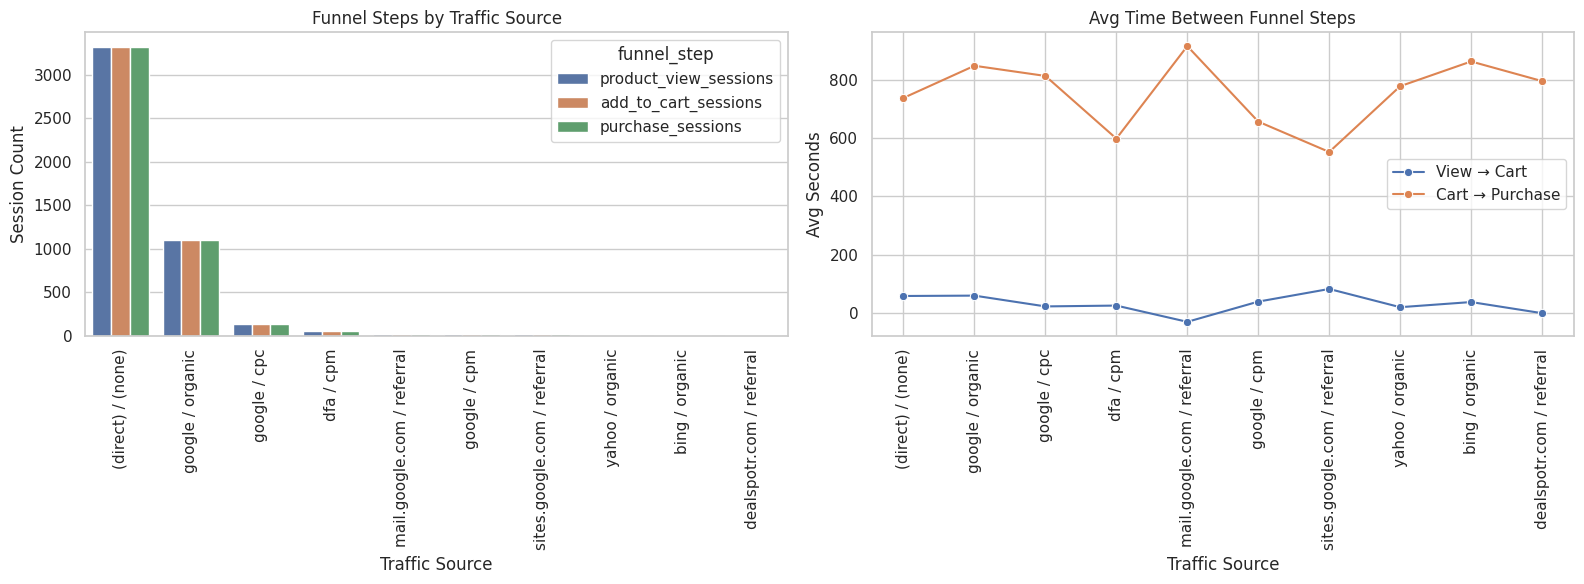

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

# --- Bar Plot: Funnel Step Sessions ---
df_melted = df.melt(id_vars="traffic_source", 
                    value_vars=["product_view_sessions", "add_to_cart_sessions", "purchase_sessions"],
                    var_name="funnel_step", value_name="sessions")

plt.subplot(1, 2, 1)
sns.barplot(data=df_melted, x="traffic_source", y="sessions", hue="funnel_step")
plt.xticks(rotation=90)
plt.title("Funnel Steps by Traffic Source")
plt.ylabel("Session Count")
plt.xlabel("Traffic Source")

# --- Line Plot: Average Time Durations ---
plt.subplot(1, 2, 2)
sns.lineplot(data=df, x="traffic_source", y="avg_view_to_cart_sec", marker='o', label="View → Cart")
sns.lineplot(data=df, x="traffic_source", y="avg_cart_to_purchase_sec", marker='o', label="Cart → Purchase")
plt.xticks(rotation=90)
plt.title("Avg Time Between Funnel Steps")
plt.ylabel("Avg Seconds")
plt.xlabel("Traffic Source")
plt.legend()

plt.tight_layout()
plt.show()


# 6.3 Funnel segmentation based on the product, product category, and price.
Segmenting the funnel based on product-level data or product categories (if available) to find:
 
 - Top converting products

- Products with high view but low purchase rates

- Category-wise conversion patterns

In [20]:
query  = f"""
WITH product_info AS (
  SELECT
    DISTINCT
      p.v2ProductName AS product_name,
      p.v2ProductCategory AS product_category,
      p.productPrice AS product_price,
      EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', t.date)) AS year
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS t,
    UNNEST(t.hits) AS h,
    UNNEST(h.product) AS p
  WHERE
    p.productPrice IS NOT NULL
    AND p.productPrice > 0
    AND p.v2ProductCategory != '(not set)'
    AND _TABLE_SUFFIX BETWEEN '20170101' AND '20171231'
),

unnested_hits AS (
  SELECT
    CONCAT(t.fullVisitorId, '-', CAST(t.visitId AS STRING)) AS session_id,
    TIMESTAMP_MILLIS(1000 * t.visitStartTime + h.time) AS hit_timestamp,
    SAFE_CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
    p.v2ProductCategory AS product_category,
    p.productPrice AS product_price
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS t,
    UNNEST(t.hits) AS h,
    UNNEST(h.product) AS p
  WHERE
    SAFE_CAST(h.eCommerceAction.action_type AS INT64) IN (2, 3, 6)
    AND p.productPrice IS NOT NULL
    AND p.productPrice > 0
    AND p.v2ProductCategory != '(not set)'
    AND _TABLE_SUFFIX BETWEEN '20170101' AND '20171231'
),

ranked_hits AS (
  SELECT
    session_id,
    action_type,
    hit_timestamp,
    product_category,
    product_price,
    ROW_NUMBER() OVER (PARTITION BY session_id, action_type ORDER BY hit_timestamp) AS rn
  FROM unnested_hits
),

view_to_cart_time AS (
  SELECT
    vh.session_id,
    vh.product_category,
    vh.product_price,
    TIMESTAMP_DIFF(ch.hit_timestamp, vh.hit_timestamp, SECOND) AS view_to_cart_seconds
  FROM ranked_hits vh
  JOIN ranked_hits ch
    ON vh.session_id = ch.session_id
    AND vh.action_type = 2
    AND ch.action_type = 3
    AND vh.rn = 1 AND ch.rn = 1
),

cart_to_purchase_time AS (
  SELECT
    ch.session_id,
    ch.product_category,
    ch.product_price,
    TIMESTAMP_DIFF(ph.hit_timestamp, ch.hit_timestamp, SECOND) AS cart_to_purchase_seconds
  FROM ranked_hits ch
  JOIN ranked_hits ph
    ON ch.session_id = ph.session_id
    AND ch.action_type = 3
    AND ph.action_type = 6
    AND ch.rn = 1 AND ph.rn = 1
),

final_agg AS (
  SELECT
    product_category,
    product_price,
    COUNT(DISTINCT session_id) AS total_sessions,
    COUNTIF(action_type = 2) AS product_view_sessions,
    COUNTIF(action_type = 3) AS add_to_cart_sessions,
    COUNTIF(action_type = 6) AS purchase_sessions
  FROM unnested_hits
  GROUP BY product_category, product_price
),

final_result AS (
  SELECT
    f.*,
    ROUND(100 * add_to_cart_sessions / NULLIF(product_view_sessions, 0), 2) AS view_to_cart_percentage,
    ROUND(100 * purchase_sessions / NULLIF(add_to_cart_sessions, 0), 2) AS cart_to_purchase_percentage,
    ROUND(100 * purchase_sessions / NULLIF(product_view_sessions, 0), 2) AS view_to_purchase_percentage,
    ROUND(AVG(v.view_to_cart_seconds), 2) AS avg_view_to_cart_sec,
    ROUND(AVG(p.cart_to_purchase_seconds), 2) AS avg_cart_to_purchase_sec
  FROM final_agg f
  LEFT JOIN view_to_cart_time v 
    ON f.product_category = v.product_category 
    AND f.product_price = v.product_price
  LEFT JOIN cart_to_purchase_time p 
    ON f.product_category = p.product_category 
    AND f.product_price = p.product_price
  GROUP BY f.product_category, f.product_price, f.total_sessions, f.product_view_sessions, f.add_to_cart_sessions, f.purchase_sessions
)

SELECT * FROM final_result
ORDER BY product_category, product_price;
    
"""
query = client.query(query)
df_segmentation_wrt_product_specs = query.to_dataframe()
df_segmentation_wrt_product_specs.to_csv('/kaggle/working/segmentation_wrt_product_specs.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [21]:
df_segmentation_wrt_product_specs

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,product_category,product_price,total_sessions,product_view_sessions,add_to_cart_sessions,purchase_sessions,view_to_cart_percentage,cart_to_purchase_percentage,view_to_purchase_percentage,avg_view_to_cart_sec,avg_cart_to_purchase_sec
0,${escCatTitle},790000,13,5,14,0,280.00,0.0,0.0,9.00,781.00
1,${escCatTitle},990000,187,86,178,0,206.98,0.0,0.0,-16.41,691.86
2,${escCatTitle},1000000,1,1,1,0,100.00,0.0,0.0,NaN,NaN
3,${escCatTitle},1200000,41,18,38,0,211.11,0.0,0.0,50.86,652.50
4,${escCatTitle},1250000,17,5,16,0,320.00,0.0,0.0,52.00,892.00
...,...,...,...,...,...,...,...,...,...,...,...
1540,Waze,18990000,14,0,0,32,NaN,NaN,NaN,NaN,NaN
1541,Wearables/Men's T-Shirts/,16990000,30,55,10,0,18.18,0.0,0.0,28.25,1612.00
1542,Wearables/Men's T-Shirts/,18990000,12,18,2,0,11.11,0.0,0.0,161.00,NaN
1543,Wearables/Men's T-Shirts/,19990000,8,14,1,0,7.14,0.0,0.0,NaN,NaN


<Axes: xlabel='product_price', ylabel='view_to_purchase_percentage'>

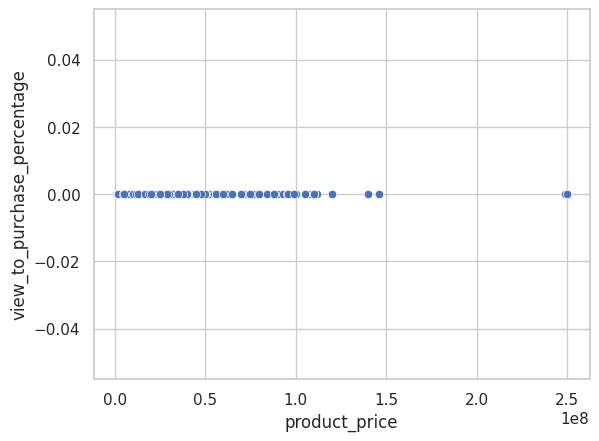

In [22]:
sns.scatterplot(data=df_segmentation_wrt_product_specs, x = 'product_price', y = 'view_to_purchase_percentage')

# Segmenting with price bucket

In [23]:
query = f"""
WITH product_info AS (
  SELECT
    DISTINCT
      p.v2ProductName AS product_name,
      p.v2ProductCategory AS product_category,
      p.productPrice AS product_price,
      EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', t.date)) AS year
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS t,
    UNNEST(t.hits) AS h,
    UNNEST(h.product) AS p
  WHERE
    p.productPrice IS NOT NULL
    AND p.productPrice > 0
    AND p.v2ProductCategory != '(not set)'
    AND _TABLE_SUFFIX BETWEEN '20170101' AND '20171231'
),

unnested_hits AS (
  SELECT
    CONCAT(t.fullVisitorId, '-', CAST(t.visitId AS STRING)) AS session_id,
    TIMESTAMP_MILLIS(1000 * t.visitStartTime + h.time) AS hit_timestamp,
    SAFE_CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
    p.v2ProductCategory AS product_category,
    p.productPrice AS product_price,
    CASE
      WHEN p.productPrice < 100 THEN 'Low'
      WHEN p.productPrice < 500 THEN 'Medium'
      ELSE 'High'
    END AS price_bucket
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS t,
    UNNEST(t.hits) AS h,
    UNNEST(h.product) AS p
  WHERE
    SAFE_CAST(h.eCommerceAction.action_type AS INT64) IN (2, 3, 6)
    AND p.productPrice IS NOT NULL
    AND p.productPrice > 0
    AND p.v2ProductCategory != '(not set)'
    AND _TABLE_SUFFIX BETWEEN '20170101' AND '20171231'
),

ranked_hits AS (
  SELECT
    session_id,
    action_type,
    hit_timestamp,
    product_category,
    product_price,
    price_bucket,
    ROW_NUMBER() OVER (PARTITION BY session_id, action_type ORDER BY hit_timestamp) AS rn
  FROM unnested_hits
),

view_to_cart_time AS (
  SELECT
    vh.session_id,
    vh.product_category,
    vh.product_price,
    vh.price_bucket,
    TIMESTAMP_DIFF(ch.hit_timestamp, vh.hit_timestamp, SECOND) AS view_to_cart_seconds
  FROM ranked_hits vh
  JOIN ranked_hits ch
    ON vh.session_id = ch.session_id
    AND vh.action_type = 2
    AND ch.action_type = 3
    AND vh.rn = 1 AND ch.rn = 1
),

cart_to_purchase_time AS (
  SELECT
    ch.session_id,
    ch.product_category,
    ch.product_price,
    ch.price_bucket,
    TIMESTAMP_DIFF(ph.hit_timestamp, ch.hit_timestamp, SECOND) AS cart_to_purchase_seconds
  FROM ranked_hits ch
  JOIN ranked_hits ph
    ON ch.session_id = ph.session_id
    AND ch.action_type = 3
    AND ph.action_type = 6
    AND ch.rn = 1 AND ph.rn = 1
),

final_agg AS (
  SELECT
    product_category,
    price_bucket,
    COUNT(DISTINCT session_id) AS total_sessions,
    COUNTIF(action_type = 2) AS product_view_sessions,
    COUNTIF(action_type = 3) AS add_to_cart_sessions,
    COUNTIF(action_type = 6) AS purchase_sessions
  FROM unnested_hits
  GROUP BY product_category, price_bucket
),

final_result AS (
  SELECT
    f.*,
    ROUND(100 * add_to_cart_sessions / NULLIF(product_view_sessions, 0), 2) AS view_to_cart_percentage,
    ROUND(100 * purchase_sessions / NULLIF(add_to_cart_sessions, 0), 2) AS cart_to_purchase_percentage,
    ROUND(100 * purchase_sessions / NULLIF(product_view_sessions, 0), 2) AS view_to_purchase_percentage,
    ROUND(AVG(v.view_to_cart_seconds), 2) AS avg_view_to_cart_sec,
    ROUND(AVG(p.cart_to_purchase_seconds), 2) AS avg_cart_to_purchase_sec
  FROM final_agg f
  LEFT JOIN view_to_cart_time v 
    ON f.product_category = v.product_category 
    AND f.price_bucket = v.price_bucket
  LEFT JOIN cart_to_purchase_time p 
    ON f.product_category = p.product_category 
    AND f.price_bucket = p.price_bucket
  GROUP BY f.product_category, f.price_bucket, f.total_sessions, f.product_view_sessions, f.add_to_cart_sessions, f.purchase_sessions
)

SELECT * FROM final_result
ORDER BY product_category, price_bucket;

"""
query = client.query(query)
df_segmentation_based_on_product = query.to_dataframe()
df_segmentation_based_on_product.to_csv('/kaggle/working/segmentation_based_product.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [24]:
df_segmentation_based_on_product

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,product_category,price_bucket,total_sessions,product_view_sessions,add_to_cart_sessions,purchase_sessions,view_to_cart_percentage,cart_to_purchase_percentage,view_to_purchase_percentage,avg_view_to_cart_sec,avg_cart_to_purchase_sec
0,${escCatTitle},High,15847,8837,27245,0,308.31,0.0,0.0,42.48,741.78
1,${productitem.product.origCatName},High,190,0,0,450,NaN,NaN,NaN,NaN,NaN
2,Accessories,High,60,0,0,136,NaN,NaN,NaN,NaN,NaN
3,Android,High,28,0,0,56,NaN,NaN,NaN,NaN,NaN
4,Apparel,High,4112,0,0,18816,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
64,Notebooks & Journals,High,284,0,0,692,NaN,NaN,NaN,NaN,NaN
65,Office,High,1874,0,0,7452,NaN,NaN,NaN,NaN,NaN
66,Tumblers/,High,1,2,0,0,0.00,NaN,0.0,NaN,NaN
67,Waze,High,174,0,0,446,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='price_bucket', ylabel='view_to_purchase_percentage'>

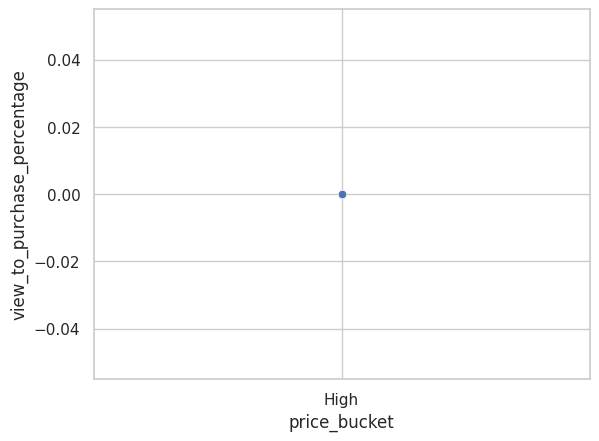

In [25]:
sns.scatterplot(data=df_segmentation_based_on_product, x = 'price_bucket', y = 'view_to_purchase_percentage')

# 6.4 Segmentation wrt Users

In [26]:
query = f"""
WITH all_sessions_2017 AS (
  SELECT
    fullVisitorId,
    visitId,
    visitStartTime,
    PARSE_DATE('%Y%m%d', date) AS session_date,
    hits
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE _TABLE_SUFFIX BETWEEN '20170101' AND '20171231'
),
first_time_users_2017 AS (
  SELECT
    fullVisitorId,
    MIN(session_date) AS first_seen_date
  FROM all_sessions_2017
  GROUP BY fullVisitorId
  HAVING first_seen_date BETWEEN '2017-01-01' AND '2017-12-31'
),
tagged_sessions AS (
  SELECT
    CONCAT(s.fullVisitorId, '-', s.visitId) AS session_id,
    s.fullVisitorId,
    s.visitId,
    s.visitStartTime,
    CASE
      WHEN f.first_seen_date = s.session_date THEN 'new'
      ELSE 'returning'
    END AS user_type,
    s.hits
  FROM all_sessions_2017 s
  LEFT JOIN first_time_users_2017 f
    ON s.fullVisitorId = f.fullVisitorId
),
unnested_hits AS (
  SELECT
    ts.session_id,
    ts.user_type,
    TIMESTAMP_MILLIS(1000 * ts.visitStartTime + h.time) AS hit_timestamp,
    CAST(h.eCommerceAction.action_type AS INT64) AS action_type
  FROM
    tagged_sessions ts,
    UNNEST(hits) AS h
  WHERE
    CAST(h.eCommerceAction.action_type AS INT64) IN (2, 3, 6)
),
ranked_hits AS (
  SELECT
    session_id,
    user_type,
    action_type,
    hit_timestamp,
    ROW_NUMBER() OVER (PARTITION BY session_id, action_type ORDER BY hit_timestamp) AS rn
  FROM unnested_hits
),
view_to_cart_time AS (
  SELECT
    vh.session_id,
    vh.user_type,
    TIMESTAMP_DIFF(ch.hit_timestamp, vh.hit_timestamp, SECOND) AS view_to_cart_seconds
  FROM ranked_hits vh
  JOIN ranked_hits ch
    ON vh.session_id = ch.session_id
    AND vh.user_type = ch.user_type
    AND vh.action_type = 2
    AND ch.action_type = 3
    AND vh.rn = 1 AND ch.rn = 1
),
cart_to_purchase_time AS (
  SELECT
    ch.session_id,
    ch.user_type,
    TIMESTAMP_DIFF(ph.hit_timestamp, ch.hit_timestamp, SECOND) AS cart_to_purchase_seconds
  FROM ranked_hits ch
  JOIN ranked_hits ph
    ON ch.session_id = ph.session_id
    AND ch.user_type = ph.user_type
    AND ch.action_type = 3
    AND ph.action_type = 6
    AND ch.rn = 1 AND ph.rn = 1
),
final_agg AS (
  SELECT
    user_type,
    COUNT(DISTINCT session_id) AS total_sessions,
    COUNTIF(action_type = 2) AS product_view_sessions,
    COUNTIF(action_type = 3) AS add_to_cart_sessions,
    COUNTIF(action_type = 6) AS purchase_sessions
  FROM unnested_hits
  GROUP BY user_type
),
final_result AS (
  SELECT
    f.*,
    ROUND(100 * add_to_cart_sessions / product_view_sessions, 2) AS view_to_cart_percentage,
    ROUND(100 * purchase_sessions / add_to_cart_sessions, 2) AS cart_to_purchase_percentage,
    ROUND(100 * purchase_sessions / product_view_sessions, 2) AS view_to_purchase_percentage,
    ROUND(AVG(v.view_to_cart_seconds), 2) AS avg_view_to_cart_sec,
    ROUND(AVG(p.cart_to_purchase_seconds), 2) AS avg_cart_to_purchase_sec
  FROM final_agg f
  LEFT JOIN view_to_cart_time v ON f.user_type = v.user_type
  LEFT JOIN cart_to_purchase_time p ON f.user_type = p.user_type
  GROUP BY f.user_type, total_sessions, product_view_sessions, add_to_cart_sessions, purchase_sessions
)

SELECT * FROM final_result
ORDER BY user_type;


"""
query = client.query(query)
df_segment_wrt_users = query.to_dataframe()
df_segment_wrt_users.to_csv('/kaggle/working/segment_wrt_users.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [27]:
df_segment_wrt_users

,user_type,total_sessions,product_view_sessions,add_to_cart_sessions,purchase_sessions,view_to_cart_percentage,cart_to_purchase_percentage,view_to_purchase_percentage,avg_view_to_cart_sec,avg_cart_to_purchase_sec
0,new,54635,130888,42751,7446,32.66,17.42,5.69,75.62,735.57
1,returning,16003,41984,22481,5991,53.55,26.65,14.27,52.63,742.74


# 7 Repeat Users Behaviours

In [28]:
query = f"""
WITH base_sessions AS (
  SELECT
    fullVisitorId,
    visitId,
    device.deviceCategory,
    trafficSource.source,
    trafficSource.medium,
    visitStartTime,
    TIMESTAMP_SECONDS(visitStartTime) AS session_start,
    CONCAT(fullVisitorId, '-', CAST(visitId AS STRING)) AS session_id
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170101' AND '20171231'
),

session_ranked AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime) AS session_rank
  FROM base_sessions
),

tagged_sessions AS (
  SELECT
    *,
    CASE 
      WHEN session_rank = 1 THEN 'first_session'
      ELSE 'repeat_session'
    END AS session_type
  FROM session_ranked
),

unnested_hits AS (
  SELECT
    ts.session_id,
    ts.session_type,
    TIMESTAMP_MILLIS(1000 * ts.visitStartTime + h.time) AS hit_timestamp,
    CAST(h.eCommerceAction.action_type AS INT64) AS action_type
  FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS s,
  UNNEST(s.hits) AS h
  JOIN tagged_sessions ts
      ON ts.fullVisitorId = s.fullVisitorId AND ts.visitId = s.visitId
  WHERE
    CAST(h.eCommerceAction.action_type AS INT64) IN (2, 3, 6)
),

ranked_hits AS (
  SELECT
    session_id,
    session_type,
    action_type,
    hit_timestamp,
    ROW_NUMBER() OVER (PARTITION BY session_id, action_type ORDER BY hit_timestamp) AS rn
  FROM unnested_hits
),

view_to_cart_time AS (
  SELECT
    vh.session_id,
    vh.session_type,
    TIMESTAMP_DIFF(ch.hit_timestamp, vh.hit_timestamp, SECOND) AS view_to_cart_seconds
  FROM ranked_hits vh
  JOIN ranked_hits ch
    ON vh.session_id = ch.session_id
    AND vh.session_type = ch.session_type
    AND vh.action_type = 2
    AND ch.action_type = 3
    AND vh.rn = 1 AND ch.rn = 1
),

cart_to_purchase_time AS (
  SELECT
    ch.session_id,
    ch.session_type,
    TIMESTAMP_DIFF(ph.hit_timestamp, ch.hit_timestamp, SECOND) AS cart_to_purchase_seconds
  FROM ranked_hits ch
  JOIN ranked_hits ph
    ON ch.session_id = ph.session_id
    AND ch.session_type = ph.session_type
    AND ch.action_type = 3
    AND ph.action_type = 6
    AND ch.rn = 1 AND ph.rn = 1
),

funnel_counts AS (
  SELECT
    session_type,
    COUNT(DISTINCT session_id) AS total_sessions,
    COUNTIF(action_type = 2) AS product_view_sessions,
    COUNTIF(action_type = 3) AS add_to_cart_sessions,
    COUNTIF(action_type = 6) AS purchase_sessions
  FROM unnested_hits
  GROUP BY session_type
),

final_result AS (
  SELECT
    f.*,
    ROUND(100 * add_to_cart_sessions / product_view_sessions, 2) AS view_to_cart_percentage,
    ROUND(100 * purchase_sessions / add_to_cart_sessions, 2) AS cart_to_purchase_percentage,
    ROUND(100 * purchase_sessions / product_view_sessions, 2) AS view_to_purchase_percentage,
    ROUND(AVG(v.view_to_cart_seconds), 2) AS avg_view_to_cart_sec,
    ROUND(AVG(p.cart_to_purchase_seconds), 2) AS avg_cart_to_purchase_sec
  FROM funnel_counts f
  LEFT JOIN view_to_cart_time v ON f.session_type = v.session_type
  LEFT JOIN cart_to_purchase_time p ON f.session_type = p.session_type
  GROUP BY f.session_type, total_sessions, product_view_sessions, add_to_cart_sessions, purchase_sessions
)

SELECT * FROM final_result
ORDER BY session_type;

"""
query = client.query(query)
df_repeat_interactions = query.to_dataframe()
df_repeat_interactions.to_csv('/kaggle/working/repeat_interactions.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [29]:
df_repeat_interactions

,session_type,total_sessions,product_view_sessions,add_to_cart_sessions,purchase_sessions,view_to_cart_percentage,cart_to_purchase_percentage,view_to_purchase_percentage,avg_view_to_cart_sec,avg_cart_to_purchase_sec
0,first_session,49269,118198,36757,5882,31.10,16.0,4.98,77.20,750.38
1,repeat_session,21479,55552,28784,7599,51.81,26.4,13.68,55.42,725.41


## Key Observations:

- Repeat visitors exhibit higher engagement and conversion:

    - View-to-Cart rate improves by ~21 percentage points (31.10% → 51.81%).

    - View-to-Purchase rate nearly triples (4.98% → 13.68%).
 
- Time to act is faster in repeat sessions, suggesting higher buying intent:

    - Repeat users add to cart ~22 seconds faster on average.




- These insights reflect the importance of retargeting and building user loyalty.



# 8 High Intent Users

- Session had at least one add-to-cart (action_type = 3)

- Session had no purchase (action_type ≠ 6)

- Optional enrichment: session had multiple product views (action_type = 2) or long view-to-cart time


In [30]:
query = f"""
WITH unnested_hits AS (
  SELECT
    CONCAT(fullVisitorId, '-', visitId) AS session_id,
    fullVisitorId AS user_id,
    visitStartTime,
    TIMESTAMP_MILLIS(1000 * visitStartTime + h.time) AS hit_timestamp,
    CAST(h.eCommerceAction.action_type AS INT64) AS action_type
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_2017*`,
    UNNEST(hits) AS h
  WHERE
    CAST(h.eCommerceAction.action_type AS INT64) IN (2, 3, 6)
),

session_actions AS (
  SELECT
    session_id,
    user_id,
    COUNTIF(action_type = 2) AS views,
    COUNTIF(action_type = 3) AS carts,
    COUNTIF(action_type = 6) AS purchases,
    MIN(hit_timestamp) AS session_start
  FROM unnested_hits
  GROUP BY session_id, user_id
),

high_intent_sessions AS (
  SELECT
    *
  FROM session_actions
  WHERE
    carts > 0 AND purchases = 0
)

SELECT
  user_id,
  session_id,
  views,
  carts,
  session_start
FROM high_intent_sessions
ORDER BY session_start
LIMIT 100

"""

query = client.query(query)
df_high_intent_user = query.to_dataframe()
df_high_intent_user.to_csv('/kaggle/working/high_intent_user.csv')

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [31]:
df_high_intent_user

,user_id,session_id,views,carts,session_start
0,6579267347193727224,6579267347193727224-1483260076,4,1,2017-01-01 08:41:51.433000+00:00
1,6240940885748983114,6240940885748983114-1483262843,3,1,2017-01-01 09:30:26.567000+00:00
2,3126958855204188424,3126958855204188424-1483266899,1,1,2017-01-01 10:35:55.542000+00:00
3,5962650912828924546,5962650912828924546-1483267040,1,1,2017-01-01 10:39:42.532000+00:00
4,4358194291331382281,4358194291331382281-1483267020,1,1,2017-01-01 10:45:19.570000+00:00
...,...,...,...,...,...
95,0047868538532140235,0047868538532140235-1483422480,2,2,2017-01-03 05:55:06.687000+00:00
96,0824218829758504216,0824218829758504216-1483423901,9,4,2017-01-03 06:12:30.681000+00:00
97,0514369130431548060,0514369130431548060-1483423954,1,1,2017-01-03 06:13:39.508000+00:00
98,9639527157885066134,9639527157885066134-1483426995,1,1,2017-01-03 07:05:32.474000+00:00
